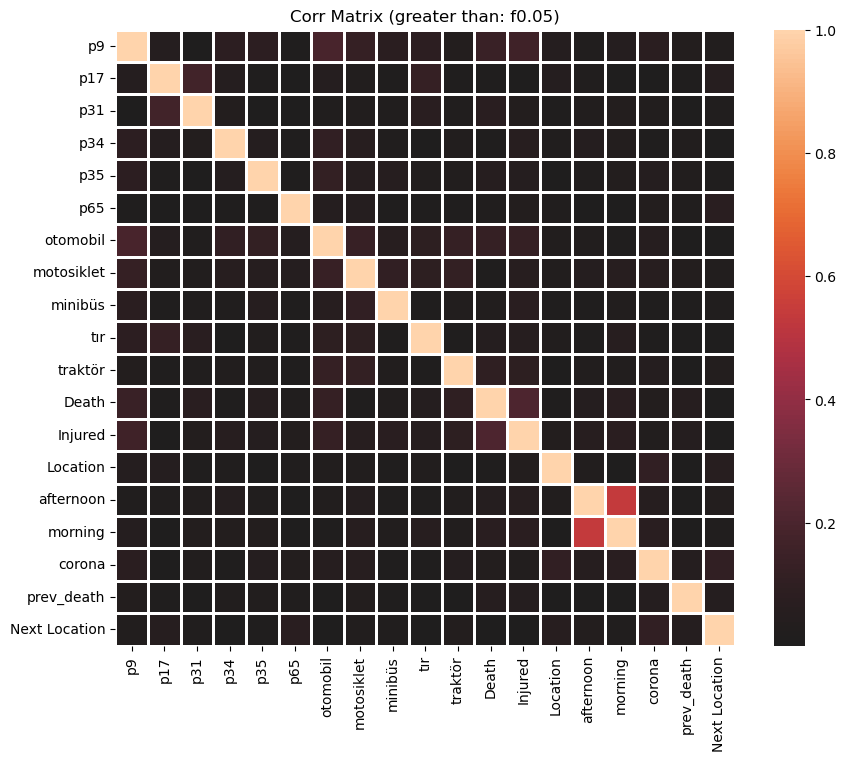

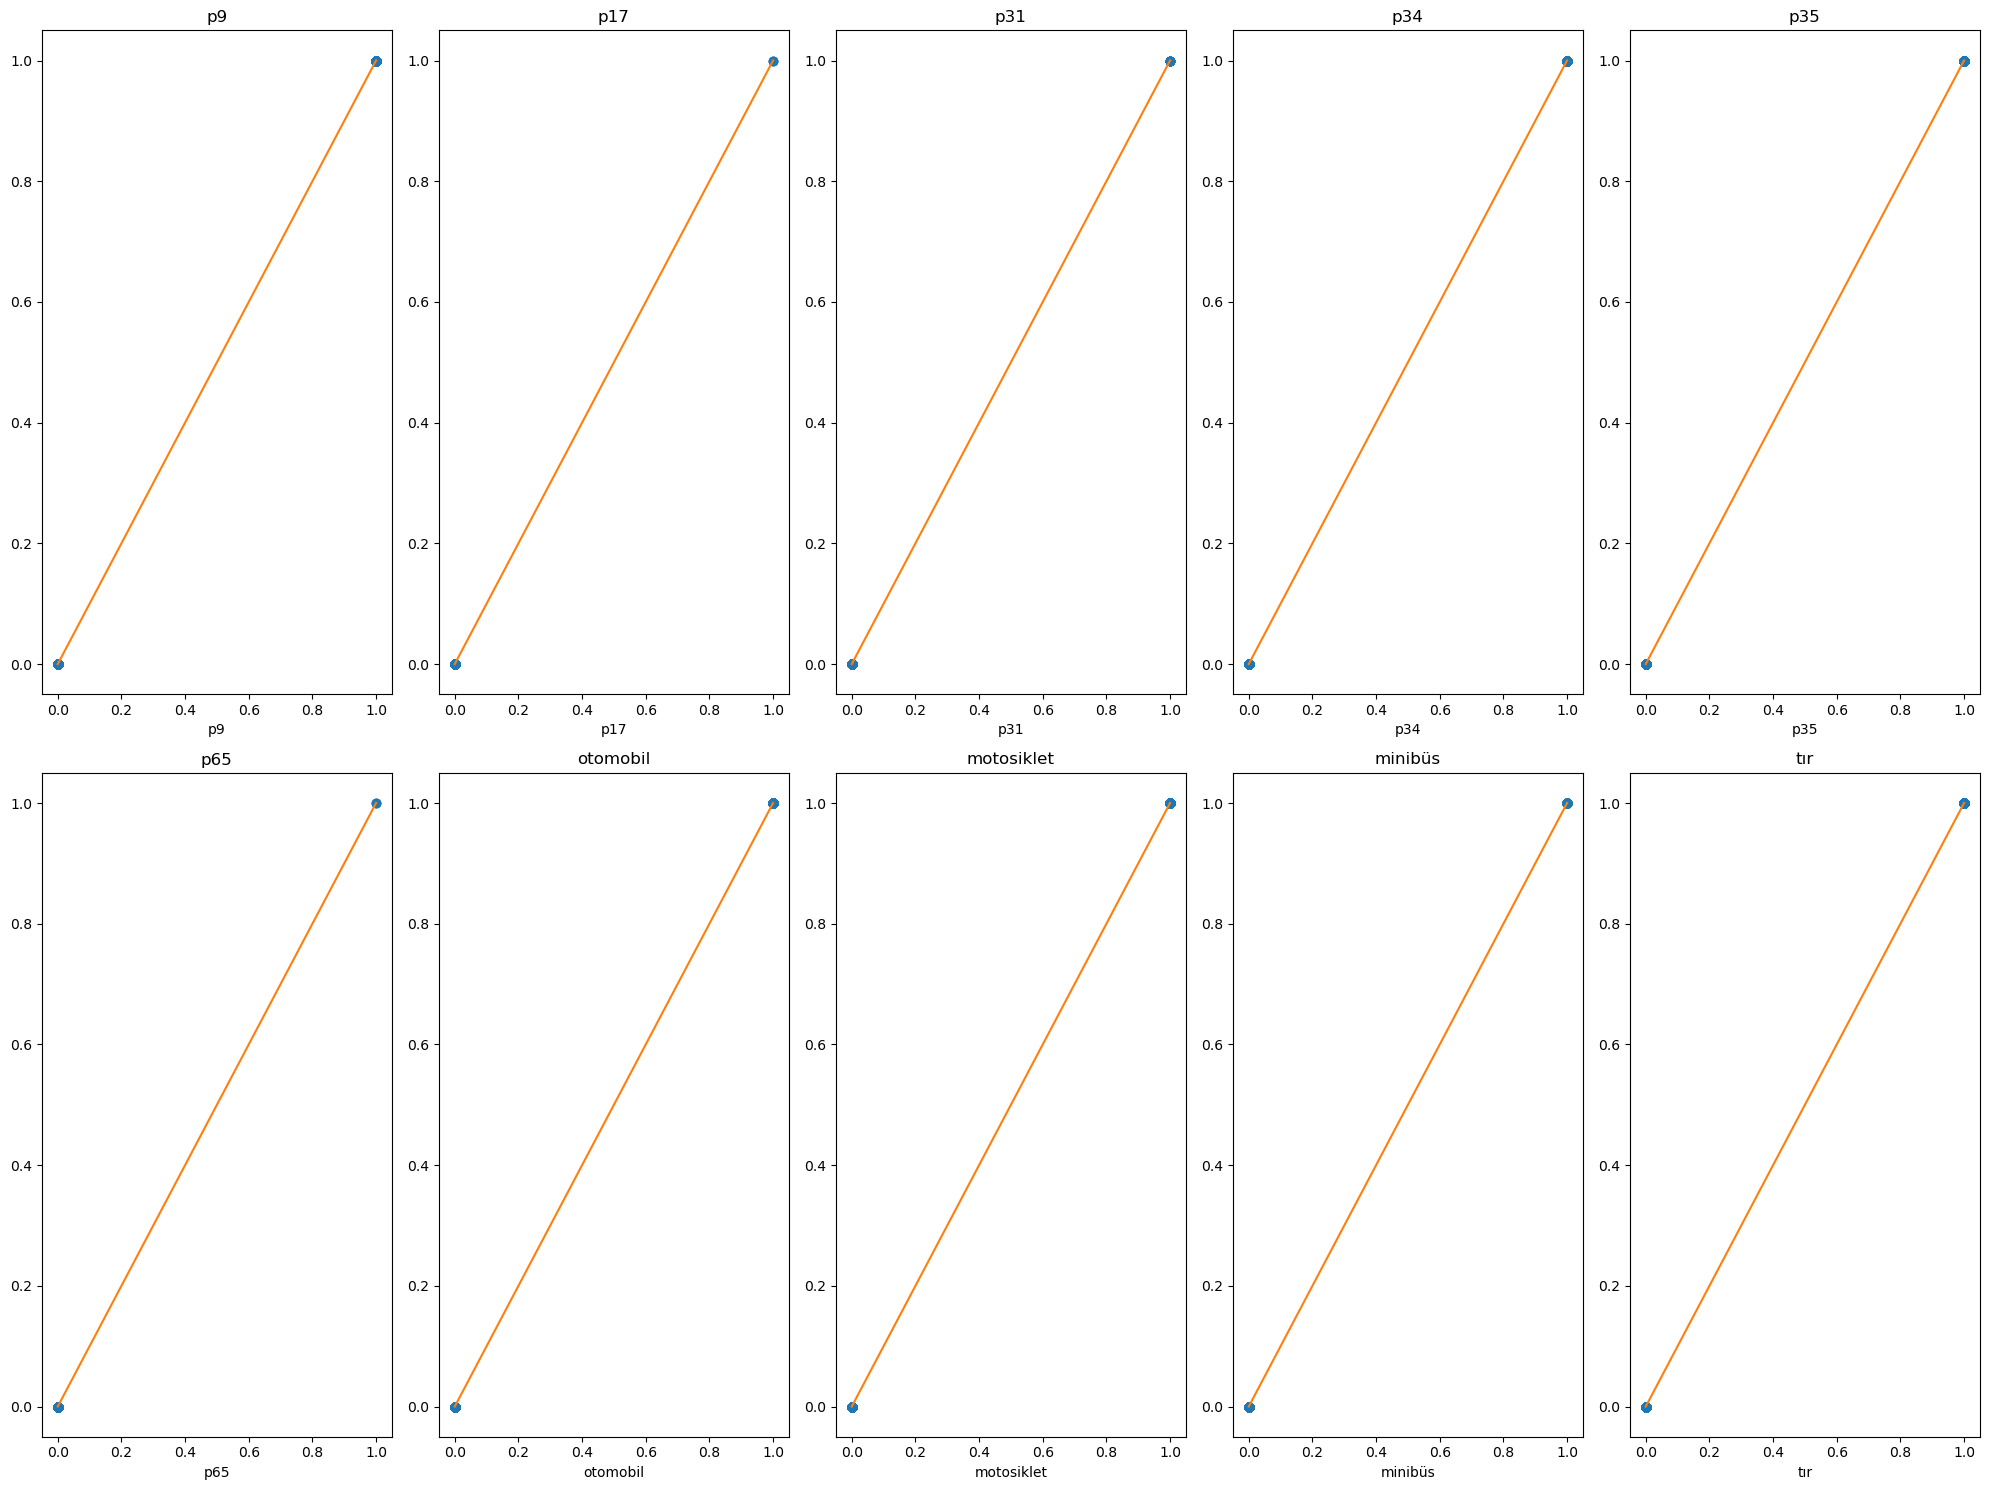

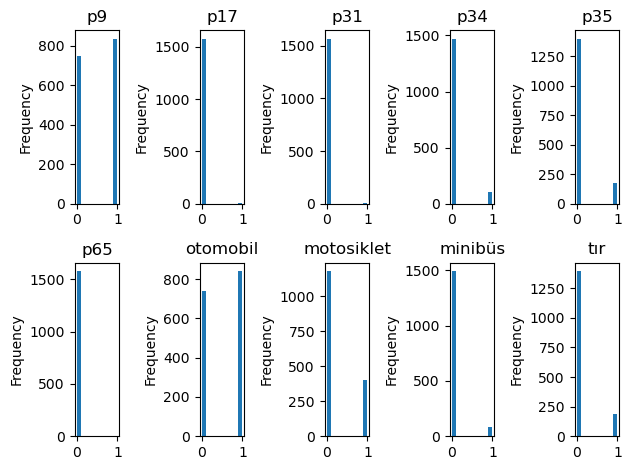

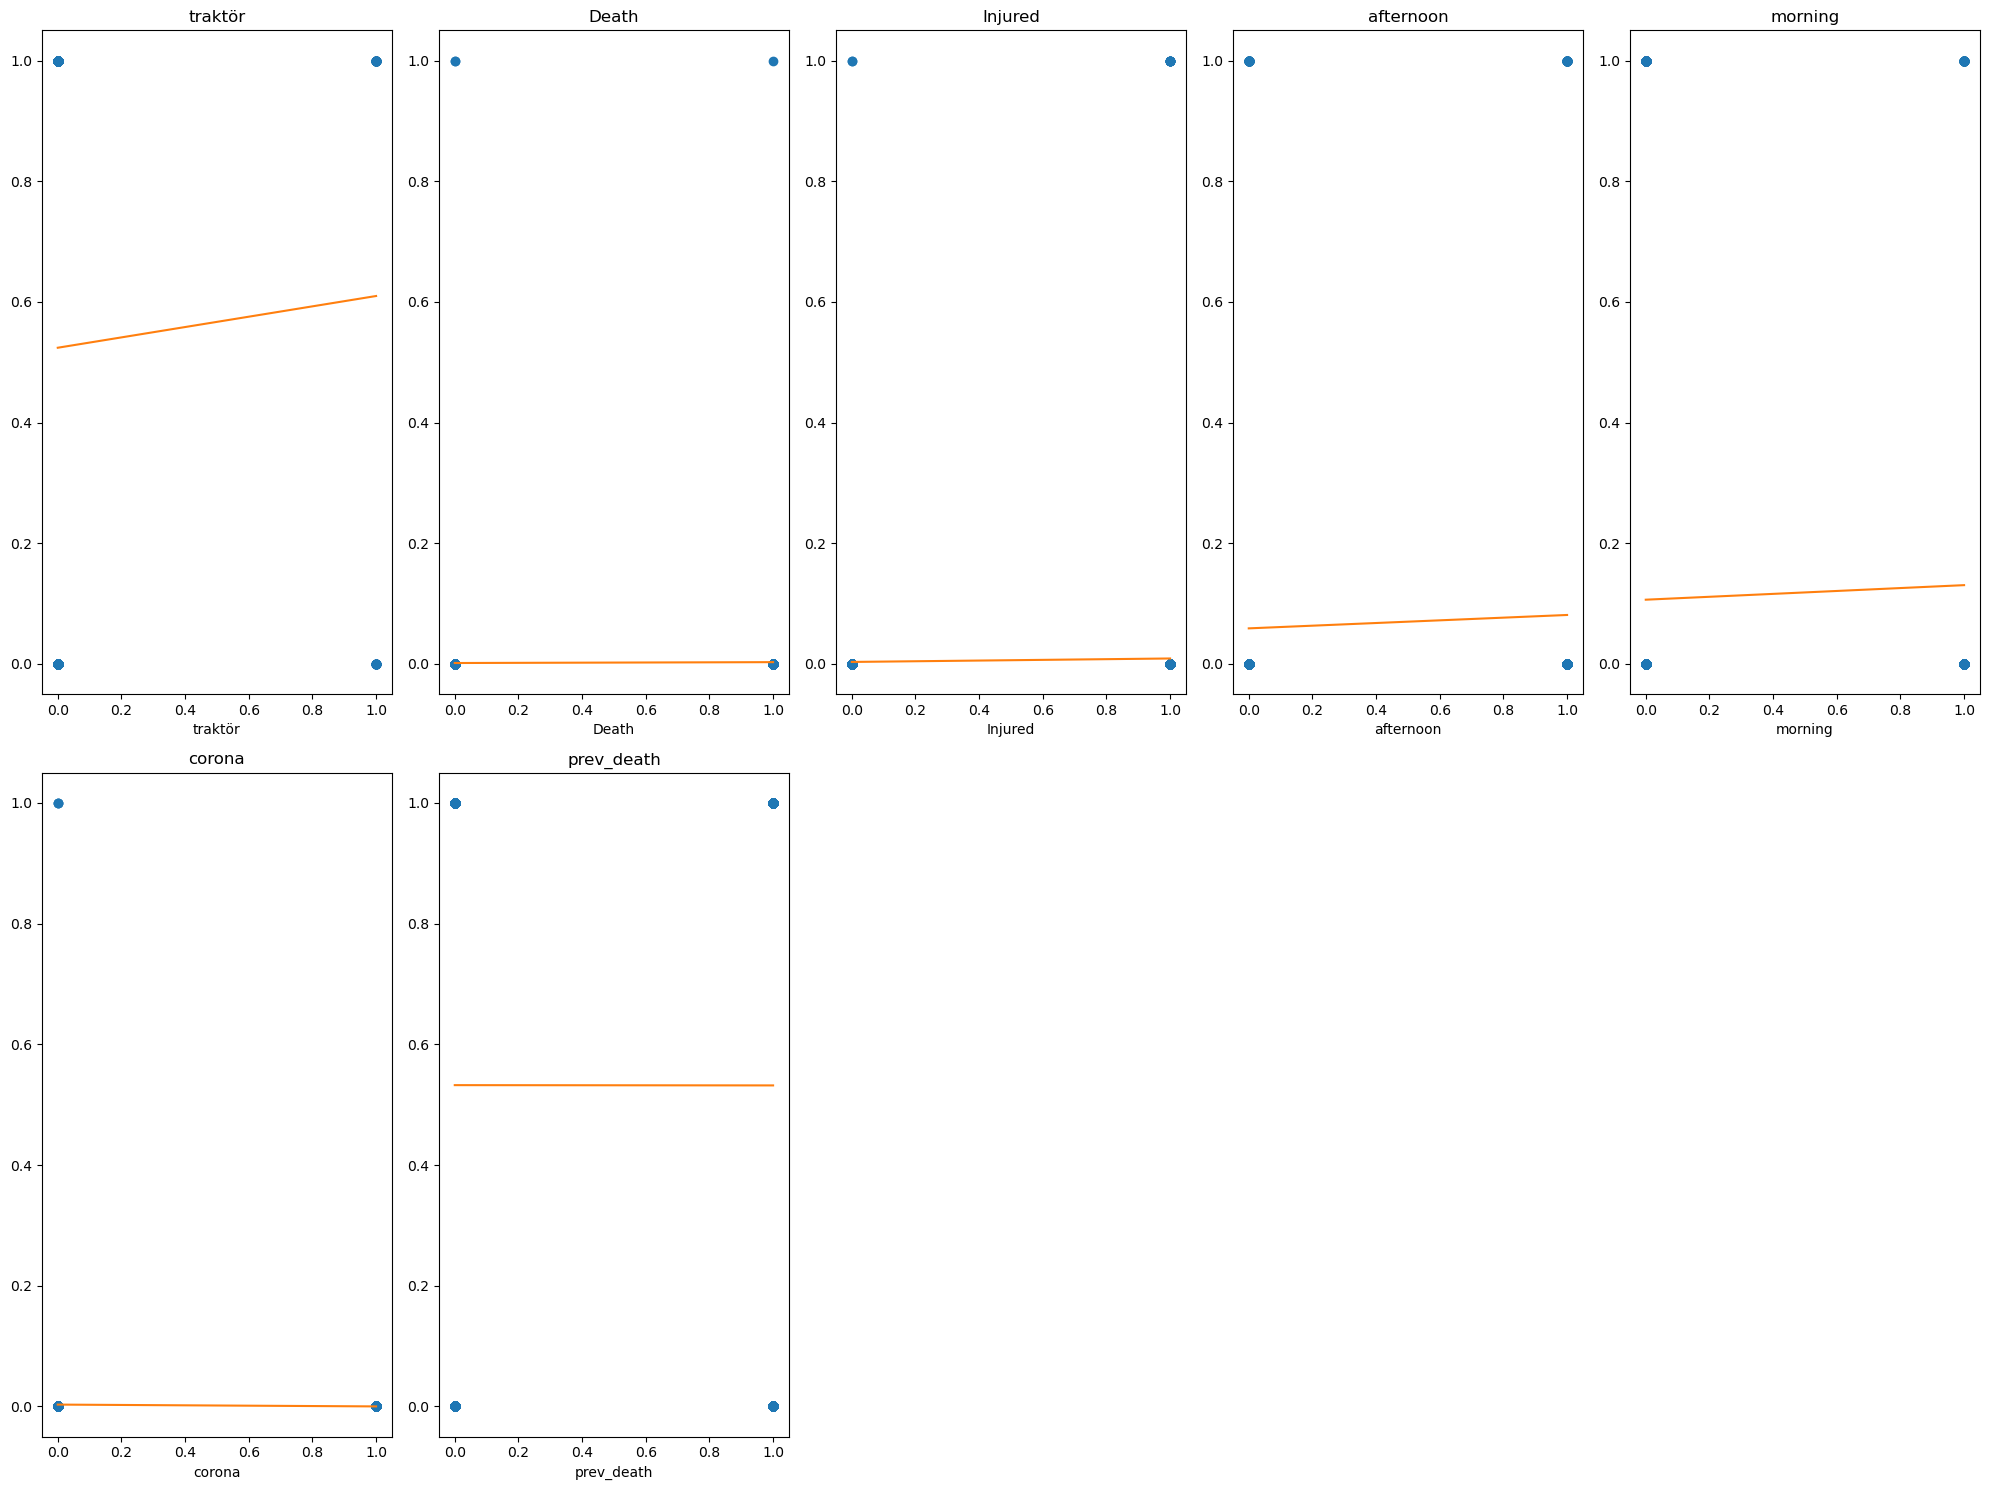

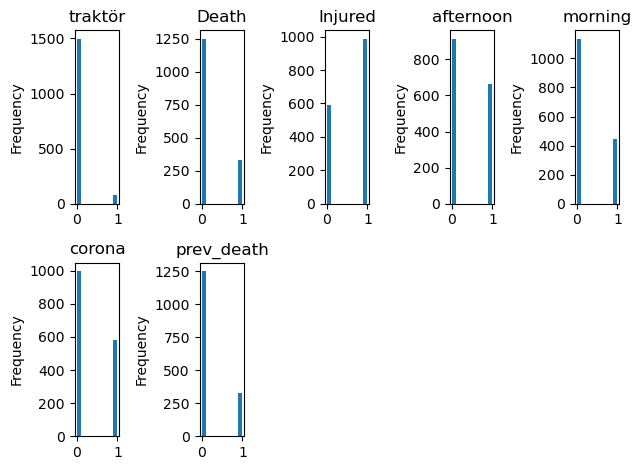

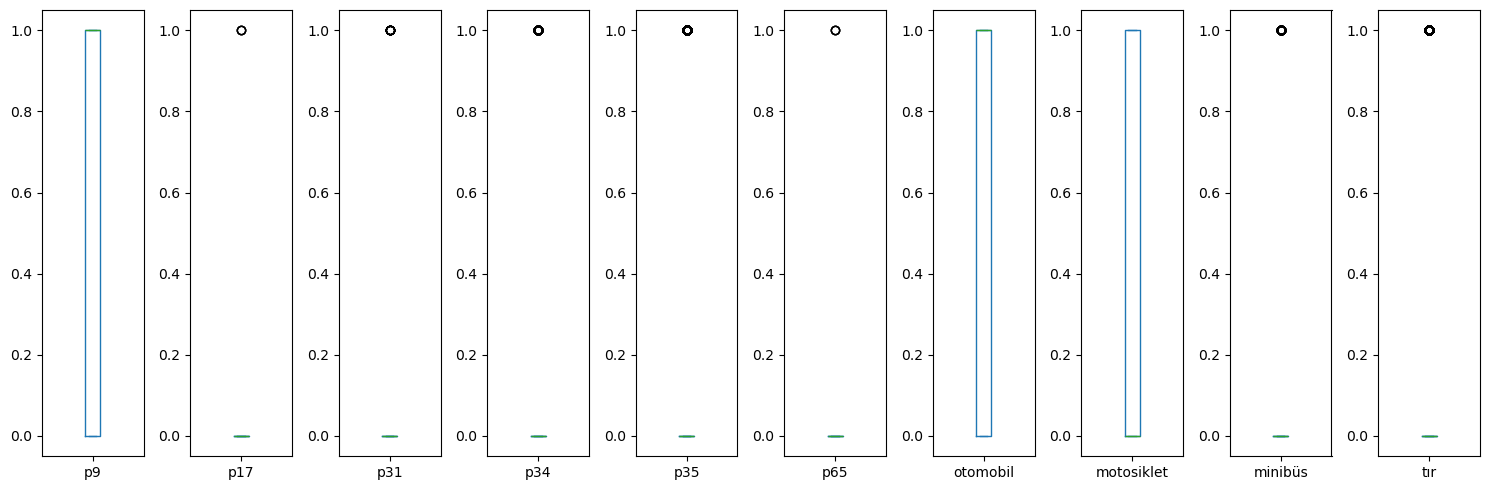

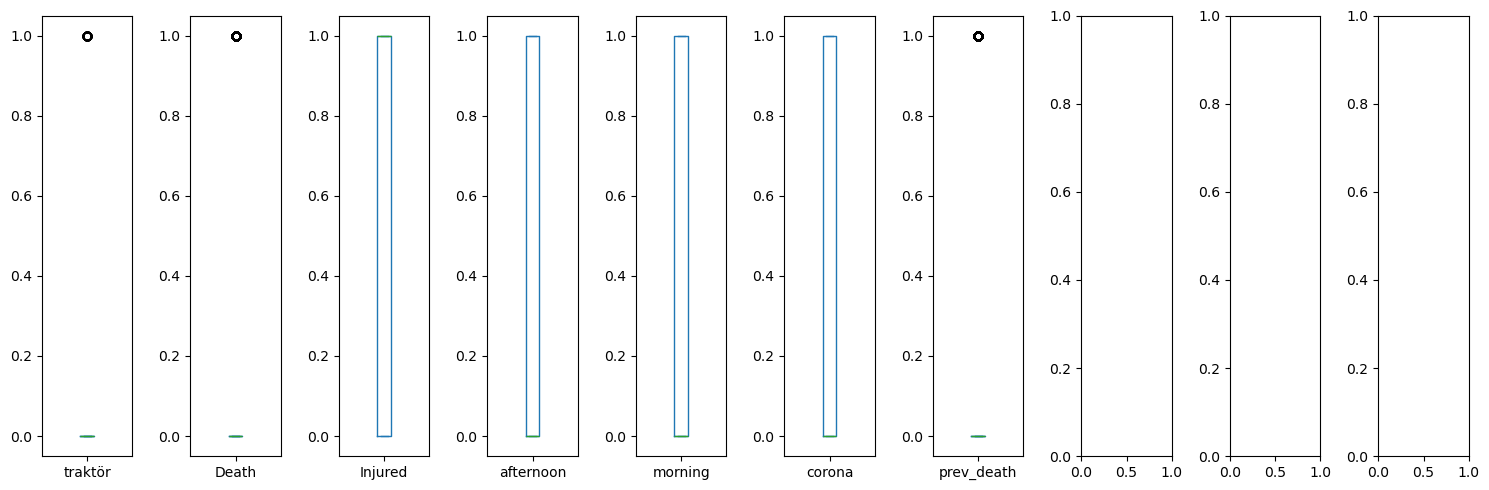

Injured
DT CV - acc :  0.5387514060742407
DT test-acc :  0.5696202531645570
DT      : 0.0483860969543457 sec

ExtraT CV - acc :  0.5775403074615673
ExtraT test-acc :  0.5981012658227848
ExtraT  : 1.7638399600982666 sec

RndFor CV - acc :  0.6036495438070242
RndFor test-acc :  0.6329113924050633
RndFor  : 1.8490426540374756 sec

KNN CV - acc :  0.5965566804149480
KNN test-acc :  0.6265822784810127
KNN     : 0.6244068145751953 sec

MLP CV - acc :  0.6131171103612049
MLP test-acc :  0.7056962025316456
MLP     : 6.403939962387085 sec

GaussNB CV - acc :  0.4098112735908012
GaussNB test-acc :  0.3639240506329114
GaussNB : 0.04188704490661621 sec

AdaBoost CV - acc :  0.6099675040619922
AdaBoost test-acc :  0.6708860759493671
AdaBoost: 0.6887526512145996 sec

GRBoost CV - acc :  0.6249656292963379
GRBoost test-acc :  0.6898734177215190
GRBoost : 0.8391571044921875 sec

LogisR CV - acc :  0.6217910261217348
LogisR test-acc :  0.6835443037974683
LogisR  : 0.21248197555541992 sec

sgd CV - acc 

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sat Mar 23 11:56:25 2024

@author: ilker
"""
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


from sklearn.exceptions import ConvergenceWarning


from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split


from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.svm import SVC


from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier

from sklearn.ensemble import VotingClassifier

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor


import time

datas = pd.read_csv('accident_news.csv')

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore")
#encode------------------------------------------------------------------------

kaz = pd.DataFrame()
split_values = datas.iloc[:, 6].str.split("'", expand=True)
for col in range(len(split_values.columns)):
    kaz[f'p{col}'] = split_values[col]
kaz.drop(columns=kaz.columns[[0,2,4,6,8,10,12,14,16,18,20]], inplace=True)
kaz = kaz.fillna(0)
kaz = kaz.astype(int)


unique_numbers = set()
for column in kaz.columns:
    unique_numbers.update(map(int, kaz[column]))

unique_numbers = sorted(unique_numbers)

plate_data = pd.DataFrame(index=kaz.index, columns=unique_numbers)

for column in kaz.columns:
    for idx, value in enumerate(kaz[column]):
        plate_data.at[idx, int(value)] = 1

plate_data = plate_data.fillna(0)

plate_data.columns = [f'p{column}' for column in plate_data.columns]

plate_data = plate_data.drop(['p0'],axis=1)

date=pd.to_datetime(datas.iloc[:,2], format='%m/%d/%Y %H:%M')
final_df = pd.concat([ plate_data , datas.iloc[:,7:] ] , axis=1)
final_df = final_df.astype('int32')
final_df =pd.concat([final_df,date,datas.iloc[:,4]], axis=1)


rows_with_none = final_df.index[final_df['Location'] == '(None,)']
for row_index in rows_with_none:
    final_df.at[row_index, 'Location'] = 'NoNe'



#feature extraction--------------------------------------------------------------------
def coldhotrain(month):
    if  month==1 :
        return 'ColdestMonthJan'
    elif month==7:
        return 'hottestMonthJuly'
    elif 1<=month<=3 or 11<=month:
        return 'RainsHigh'
    else:
        return 

coldhotrain_month = final_df['Date'].dt.month.apply(coldhotrain)#In January? or in july? or is 11-12-1-2-3
df_encoded = pd.get_dummies(coldhotrain_month).astype(int)
final_df = pd.concat([final_df, df_encoded], axis=1)
#feature extraction--------------------------------------------------------------------
def get_timeofday(hour):
    if 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 18:
        return 'afternoon'
    elif 18 <= hour <= 23:
        return 'evening'
    else:
        return 'night'
#feature extraction--------------------------------------------------------------------
timeofday = final_df['Date'].dt.hour.apply(get_timeofday)
df_encoded_day = pd.get_dummies(timeofday).astype(int)
final_df = pd.concat([final_df, df_encoded_day], axis=1)

def get_year(year):
    if 2020 <= year < 2022:
        return 1
    else:
        return 0

final_df['corona'] = final_df['Date'].dt.year.apply(get_year)


# previous values----------------------------------------------------------------------
final_df['prev_location'] = final_df['Location'].shift(1)
final_df['prev_location'] = final_df['prev_location'].astype('category').cat.codes
final_df['prev_death'] = final_df['Death'].shift(1)
final_df['prev_ınjured'] = final_df['Injured'].shift(1)

final_df = final_df.drop(['Date','Year','Month','Day','Hour','Minute'],axis=1)
final_df = final_df.drop(final_df.index[0])

#--------------------------------------------------------------------------------------
corr_df=final_df.copy()
#67 71
corr_df['Location'] = corr_df['Location'].astype('category').cat.codes

corr_df['prev_location'] = corr_df['Location'].shift(1)
corr_df['prev_location'] = corr_df['prev_location'].fillna(14)#NoNe fill meanless loc 
corr_df['prev_location'] = corr_df['prev_location'].astype('category')

corr_df['Next Location'] = corr_df['Location'].shift(-1)
corr_df['Next Location'] = corr_df['Next Location'].fillna(14)#NoNe fill meanless loc 
corr_df['Next Location'] = corr_df['Next Location'].astype('category')


#corr------------------------------------------------------------------------
correlation_with_target = {}
columns_to_drop_target = {}

for i in [67,68,81]:#death,injured,nextlocation
    correlation_matrix = corr_df.corr()
    correlation_with_target[i] = correlation_matrix.iloc[i].abs().sort_values(ascending=False)
    threshold = 0.05
    columns_to_drop_target[i] = correlation_with_target[i][correlation_with_target[i] < threshold].index

columns_to_drop = set(columns_to_drop_target[67]).intersection(columns_to_drop_target[68], columns_to_drop_target[81])

corr_df = corr_df.drop(columns=columns_to_drop)

plt.figure(figsize=(10, 8))
corr2=np.abs(corr_df.corr(method='pearson'))
sns.heatmap(corr2, annot=False, fmt=".2f", linewidths=0.9, center=0)
plt.title(f"Corr Matrix (greater than: f{threshold})")


df_graph = corr_df.drop(['Location','Next Location'],axis=1)
#draw------------------------------------------------------------------------
total_columns = len(df_graph.columns)

num_cols_per_plot = 10

num_plots = total_columns // num_cols_per_plot
if total_columns % num_cols_per_plot != 0:
    num_plots += 1

for plot_index in range(num_plots):
    start_index = plot_index * num_cols_per_plot
    end_index = min((plot_index + 1) * num_cols_per_plot, total_columns)
    
    plt.figure(figsize=(20, 15))
    #
    for i, col in enumerate(df_graph.columns[start_index:end_index]):
        output= df_graph.iloc[:,i]
        features = df_graph.drop(columns=[corr_df.columns[i]])
        plt.subplot(2, 5, i+1)  
        x = df_graph[col]
        y = output
        plt.plot(x, y, 'o')
        plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
        plt.title(col)
        plt.xlabel(col)

    plt.tight_layout()
    plt.show()
    #hist
    for i, col in enumerate(df_graph.columns[start_index:end_index]):
        plt.subplot(2, 5, i+1)  
        df_graph[col].hist(bins=10, grid=False)
        plt.title(col)
        plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

#box

for i in range(0, len(df_graph.columns), 10):
    subset_columns = df_graph.columns[i:i+10]  # Select the relevant column range
    fig, axes = plt.subplots(1, 10, figsize=(15, 5), sharex=False, sharey=False)
    for idx, col in enumerate(subset_columns):
        df_graph[col].plot(kind='box', ax=axes[idx])
    plt.tight_layout()
    plt.show()

#Pre
outputs=corr_df[['Injured', 'Death', 'Next Location']]


inputs = corr_df.drop(['Death','Injured','Next Location'],axis=1)

#classification------------------------------------------------------------------------

for index in range(0,3):
    filename=outputs.iloc[:,index].name
    print(outputs.iloc[:,index].name)
   
    # Separate data into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(inputs, outputs.iloc[:,index], test_size=0.2,train_size=0.8, random_state=47,shuffle=True)

    #Loading the models to be tried------------------------------------------------------------------------------
    models = []
    
    models.append(('DT', DecisionTreeClassifier()))
    models.append(('ExtraT', ExtraTreesClassifier()))
    models.append(('RndFor', RandomForestClassifier()))
    
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('MLP',MLPClassifier()))
    models.append(('GaussNB',GaussianNB()))
    
    models.append(('AdaBoost',AdaBoostClassifier()))
    models.append(('GRBoost',GradientBoostingClassifier()))
    
    #models.append(('GaussPC',GaussianProcessClassifier()))
    
    models.append(('LogisR', LogisticRegression()))
    
    models.append(('sgd',SGDClassifier()))
    
    
    #models.append(( 'histgb',HistGradientBoostingClassifier()))

    #SVR
    models.append(('SVC-Linear', SVC(kernel="linear")))
    models.append(('SVC-RBF', SVC(kernel='rbf')))
    models.append(('SVC-Sigmoid', SVC(kernel="sigmoid")))
    models.append(('SVC-Poly2', SVC(kernel="poly",degree=2)))
    models.append(('SVC-Poly3', SVC(kernel="poly",degree=3)))
    
    #ANN
    models.append(('ANN-lbfgs',MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(20,10,5), random_state=7)))
    models.append(('ANN-sgd',MLPClassifier(solver='sgd', alpha=1e-5,hidden_layer_sizes=(20,10,5), random_state=7)))
    models.append(('ANN-adam',MLPClassifier(solver='adam', alpha=1e-5,hidden_layer_sizes=(20,10,5), random_state=7)))
    
    #Boosting
    #models.append(('xgb',xgb.XGBRegressor(verbosity=0,learning_rate = 0.01,max_depth= 5,n_estimators= 300,subsample= 0.8)))
    #models.append(('lgb',lgb.LGBMRegressor(verbose=-1)))
    #models.append(('catb',CatBoostRegressor(verbose=False)))
    
    #Testing models------------------------------------------------------------------------------
    num_folds = 10
    results = {}

    start_time0 = time.time()
    for name, model in models:
        start_time = time.time()
        
        skfold = StratifiedKFold(n_splits=num_folds,shuffle=True,random_state=47)
        cv_results = cross_val_score(model, x_train, y_train, cv=skfold, scoring="accuracy")
        
        mean_accuracy = cv_results.mean()
        
        model.fit(x_train, y_train)
        test_accuracy = model.score(x_test, y_test)
        results[name] = test_accuracy
        
        
        print(f"{name} CV - acc :  {mean_accuracy:.16f}")
        print(f"{name} test-acc :  {test_accuracy:.16f}")
        
       
        end_time = time.time();elapsed_time = end_time - start_time;print(f"{name.ljust(8)}: {elapsed_time} sec\n")
        
    end_time0 = time.time();elapsed_time = end_time0 - start_time0;print(f"All models:{elapsed_time} sec")
        

    print("\n")
    print(filename)
    best_model = max(results, key=results.get)
    print("best dependOnTest: ", best_model)


    models_dict = dict(models)
    # Train the best model
    best_model_instance = models_dict.get(best_model)
    best_model_instance.fit(x_train, y_train)

    # Evaluate the performance of the best model on the test set
    test_accuracy = best_model_instance.score(x_test, y_test)
    print("Test set test-acc (best model):", test_accuracy)

    # Calculate evaluation metrics for the best model
    y_pred = best_model_instance.predict(x_test)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    # Print the evaluation metrics for the best model
    print("\nEvaluation metric scores for best model which is {}:".format(best_model))
    print("Test set accuracy:", test_accuracy)
    print("Test set precision:", precision)
    print("Test set recall:", recall)
    print("Test set F1 score:", f1)
 
    import pickle

    best_model = max(results, key=results.get)
    print("Best model:", best_model)

    best_model_instance = models_dict.get(best_model)

    with open(f'{filename}best_model.pkl', 'wb') as f:
        pickle.dump(best_model_instance, f)

    print("\n")